In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
 
#import lightgbm as lgb
import catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('course_project_test.csv')

In [3]:
df1 = deepcopy(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [5]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


## Обработка категориальных переменных

### Years in current job

In [6]:
df['Years in current job'] = df['Years in current job'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [7]:
df['Years in current job'].value_counts()

1    2414
0      86
Name: Years in current job, dtype: int64

### Home Ownership

In [8]:
def process_ownerchip(value):
    if value in ['Own Home', 'Rent']:
        return 0
    else:
        return 1

df['Home Ownership'] = df['Home Ownership'].apply(process_ownerchip)

In [9]:
df['Home Ownership'].value_counts()

0    1268
1    1232
Name: Home Ownership, dtype: int64

### Term

In [10]:
df['Term'] = df['Term'].apply(lambda x: 0 if x == 'Short Term' else 1)

In [11]:
df['Term'].value_counts()

0    1861
1     639
Name: Term, dtype: int64

### Purpose

In [12]:
def process_purpose(value):
    columns_0 = ['debt consolidation',
            'other',    
            'home improvements',
            'take a trip',
            'buy a car',
            'wedding',
            'buy house',
            'medical bills',
            'major purchase']
    columns_1 = ['business loan',
                 'small business']
    if value in columns_0:
        return 0
    elif value in columns_1:
        return 1
    else:
        return 2

df['Purpose'] = df['Purpose'].apply(process_purpose)

### Tax Liens

In [13]:
def process_tax(value):
    columns_0 = [0, 1]
    columns_1 = range(2, 6)
    columns_3 = [6, 7]
    if value in columns_0:
        return 0
    elif value in columns_1:
        return 1
    else:
        return 2

df['Tax Liens'] = df['Tax Liens'].apply(process_tax)

### Years of Credit History

In [14]:
df['Years of Credit History'] /= 5
df['Years of Credit History'] = df['Years of Credit History'].astype(int)

In [15]:
def convert_years_credit_history(value):

    if (value in [0, 1, 4]) or value >= 6:
        return 0
    elif value in [2, 3, 5]:
        return 1
df['Years of Credit History'] = df['Years of Credit History'].astype('int')
df['Years of Credit History'] = df['Years of Credit History'].apply(convert_years_credit_history)

### Number of Credit Problems

In [16]:
df['Number of Credit Problems'] = df['Number of Credit Problems'].apply(lambda x: 1 if x > 1 else 0)

### Number of Credit Problems + Tax Lies

In [17]:
df_clust = df.loc[:, ['Tax Liens', 'Number of Credit Problems']]

In [18]:
with open('cluster_scaler.bin', 'rb') as f:
    scaler = pickle.load(f)
train_scaled = scaler.transform(df_clust)

In [19]:
inertia_arr = []
for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=42)
    temp_model.fit(train_scaled)
    inertia_arr.append(temp_model.inertia_ )

<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)


In [20]:
with open('cluster_model.bin', 'rb') as f:
    model = pickle.load(f)

In [21]:
df['tax_problems'] = model.fit_predict(train_scaled)

### Итого категориальные признаки:

In [22]:
CAT_FEATURES = ['Years in current job', 'Home Ownership', 'Term', 'Purpose', 
                'Years of Credit History', 'tax_problems']

In [23]:
df[CAT_FEATURES].describe()

,Years in current job,Home Ownership,Term,Purpose,Years of Credit History,tax_problems
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.965600,0.492800,0.255600,0.019600,0.656400,1.009200
std,0.182291,0.500048,0.436285,0.157562,0.475005,0.130852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000


In [24]:
df[CAT_FEATURES] = df[CAT_FEATURES].astype('uint8')
df['tax_problems'] = df['tax_problems'].astype(object)
df['Purpose'] = df['Purpose'].astype(object)
df = pd.get_dummies(df)

In [25]:
CAT_FEATURES = ['Years in current job', 'Home Ownership', 'Term',
 'Years of Credit History', 'Purpose_0', 'Purpose_1', 'Purpose_2',
 'tax_problems_0', 'tax_problems_1', 'tax_problems_2']
df[CAT_FEATURES].describe()

,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.965600,0.492800,0.255600,0.656400,0.983200,0.014000,0.002800,0.004000,0.982800,0.013200
std,0.182291,0.500048,0.436285,0.475005,0.128547,0.117514,0.052851,0.063132,0.130042,0.114153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Числовые признаки

In [26]:
with open('lambdas.bin', 'rb') as f:
    lambdas = pickle.load(f)

In [27]:
lambdas

{'max_credit_lambda': 0.22046164596449688,
 'credit_balance_lambda': 0.35171364548679723,
 'loan_amount_lambda': 0.3620896643157912,
 'number_accounts_lambda': 0.19648893786669672,
 'month_dept_lambda': 0.438109113536189,
 'annual_income_lambda': -0.013750754533739432,
 'credit_score_lambda': 18.64423567315302}

### Maximum Open Credit

In [28]:
df['Maximum Open Credit'].median()

478676.0

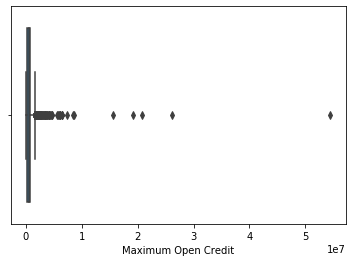

In [29]:
sns.boxplot(df['Maximum Open Credit'])

In [30]:
quant25, quant75 = np.quantile(df['Maximum Open Credit'], [.25, .75])
iqr = sp.stats.iqr(df['Maximum Open Credit'])
df.loc[(df['Maximum Open Credit'] < quant25-3*iqr)|(df['Maximum Open Credit'] > quant75+3*iqr), 'Maximum Open Credit'] = 478676.0

In [31]:
df['Maximum Open Credit'].sort_values(ascending=False).head(10)

1029    2370874.0
837     2353670.0
179     2323442.0
1147    2301772.0
647     2292136.0
2283    2289430.0
1143    2287780.0
210     2284326.0
1084    2280476.0
796     2276406.0
Name: Maximum Open Credit, dtype: float64

In [32]:
df['Maximum Open Credit'] = sp.stats.yeojohnson(df['Maximum Open Credit'], lambdas['max_credit_lambda'])

In [33]:
df['Maximum Open Credit'].describe()

count    2500.000000
mean       76.132053
std        14.462224
min         0.000000
25%        67.420887
50%        76.536286
75%        85.314172
max       110.833245
Name: Maximum Open Credit, dtype: float64

### Current Credit Balance

In [34]:
df['Current Credit Balance'] = sp.stats.yeojohnson(df['Current Credit Balance'], lambdas['credit_balance_lambda'])

### Current Loan Amount

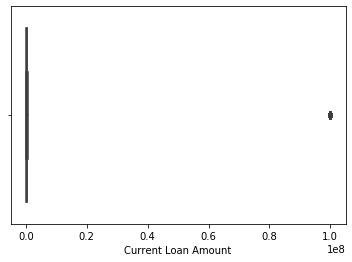

In [35]:
sns.boxplot(df['Current Loan Amount'])

In [36]:
df['Current Loan Max'] = (df['Current Loan Amount'] / 99999999.0)
df['Current Loan Max'] = df['Current Loan Max'].astype(int)
CAT_FEATURES.append('Current Loan Max')

In [37]:
df['Current Loan Max'].value_counts()

0    2203
1     297
Name: Current Loan Max, dtype: int64

In [38]:
CAT_FEATURES

['Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'tax_problems_1',
 'tax_problems_2',
 'Current Loan Max']

In [39]:
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = 264704.0

In [40]:
df['Current Loan Amount'] = sp.stats.yeojohnson(df['Current Loan Amount'], lambdas['loan_amount_lambda'])

In [41]:
df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max
count,2500.000000,1.987000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,1142.000000,2497.000000,...,2500.000000,2500.000000,1987.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.492800,1.366922e+06,0.965600,0.004800,11.184400,0.656400,76.132053,0.017200,34.181261,0.106928,...,212.588524,18271.340000,1234.516860,0.983200,0.014000,0.002800,0.004000,0.982800,0.013200,0.118800
std,0.500048,9.171252e+05,0.182291,0.079872,4.852774,0.475005,14.462224,0.130042,22.024277,0.357189,...,75.355344,11543.881469,1740.219442,0.128547,0.117514,0.052851,0.063132,0.130042,0.114153,0.323618
min,0.000000,1.065330e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,93.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.523115e+05,1.000000,0.000000,8.000000,0.000000,67.420887,0.000000,16.000000,0.000000,...,165.849967,10024.750000,710.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.178475e+06,1.000000,0.000000,10.000000,1.000000,76.536286,0.000000,30.000000,0.000000,...,207.919914,16642.500000,731.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.629734e+06,1.000000,0.000000,14.000000,1.000000,85.314172,0.000000,50.000000,0.000000,...,254.616172,24146.000000,743.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.497561e+07,1.000000,2.000000,48.000000,1.000000,110.833245,1.000000,82.000000,5.000000,...,686.670844,93555.000000,7480.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Number of Open Accounts

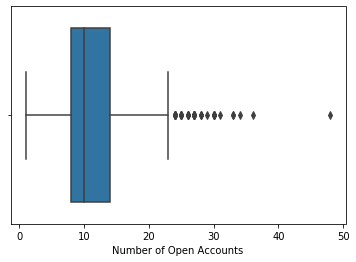

In [42]:
sns.boxplot(df['Number of Open Accounts'])

In [43]:
mdn = df['Number of Open Accounts'].median()
mdn

10.0

In [44]:
df['Number of Open Accounts'] = df['Number of Open Accounts'].apply(lambda x: 10 if x > 25 else x)

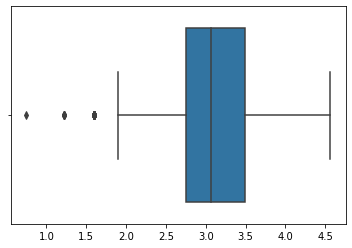

In [45]:
sns.boxplot(sp.stats.yeojohnson(df['Number of Open Accounts'], lambdas['number_accounts_lambda']))

In [46]:
df['Number of Open Accounts'] = sp.stats.yeojohnson(df['Number of Open Accounts'], lambdas['number_accounts_lambda'])

### Monthly Debt

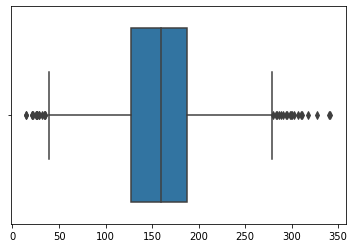

In [47]:
sns.boxplot(sp.stats.yeojohnson(df['Monthly Debt'], lambdas['month_dept_lambda']))

In [48]:
df['Monthly Debt'] = sp.stats.yeojohnson(df['Monthly Debt'], lambdas['month_dept_lambda'])

### Annual Income

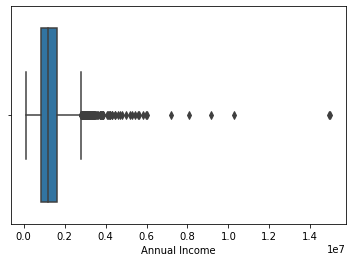

In [49]:
sns.boxplot(df['Annual Income'])

In [50]:
df_with_income = df.loc[(df['Annual Income'] >= 0)]

In [51]:
quant25, quant75 = np.quantile(df_with_income['Annual Income'], [.25, .75])
iqr = sp.stats.iqr(df_with_income['Annual Income'])

In [52]:
df_with_income = df_with_income.loc[(df_with_income['Annual Income'] > quant25-3*iqr) &
                                           (df_with_income['Annual Income'] < quant75+3*iqr)]

In [53]:
df1 = deepcopy(df)

In [54]:
df1 = df1[CAT_FEATURES+['Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Annual Income']]

In [55]:
df1.describe()

,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max,Maximum Open Credit,Number of Open Accounts,Current Loan Amount,Current Credit Balance,Monthly Debt,Annual Income
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,1.987000e+03
mean,0.965600,0.492800,0.255600,0.656400,0.983200,0.014000,0.002800,0.004000,0.982800,0.013200,0.118800,76.132053,3.106797,254.958720,212.588524,157.270117,1.366922e+06
std,0.182291,0.500048,0.436285,0.475005,0.128547,0.117514,0.052851,0.063132,0.130042,0.114153,0.323618,14.462224,0.606154,56.011899,75.355344,47.018514,9.171252e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.742567,87.952715,0.000000,14.423099,1.065330e+05
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,67.420887,2.747838,221.198228,165.849967,126.941547,8.523115e+05
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,76.536286,3.063028,251.165905,207.919914,159.072850,1.178475e+06
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,85.314172,3.487800,291.813659,254.616172,187.645910,1.629734e+06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,110.833245,4.564237,374.353278,686.670844,341.504506,1.497561e+07


In [56]:
df1.loc[df_with_income.index, 'Annual Income'] = df_with_income['Annual Income']

In [57]:
df_income_res = df1.loc[pd.isnull(df1['Annual Income'])]

In [58]:
NUM_FEAT = ['Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [59]:
with open('annual_scaler.bin', 'rb') as f:
    scaler = pickle.load(f)

In [60]:
df_income_res[NUM_FEAT] = scaler.transform(df_income_res[NUM_FEAT])

<ipython-input-60-7639fb00f29e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income_res[NUM_FEAT] = scaler.transform(df_income_res[NUM_FEAT])
/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [61]:
with open('annual_regressor.bin', 'rb') as f:
    regressor = pickle.load(f)

In [62]:
FEATURES = CAT_FEATURES + NUM_FEAT
FEATURES

['Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'tax_problems_1',
 'tax_problems_2',
 'Current Loan Max',
 'Maximum Open Credit',
 'Number of Open Accounts',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt']

In [63]:
df_income_res['Annual Income'] = regressor.predict(df_income_res.loc[:, FEATURES])
df_income_res['Annual Income'].describe()

<ipython-input-63-44489f7aa765>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income_res['Annual Income'] = regressor.predict(df_income_res.loc[:, FEATURES])


count    5.130000e+02
mean     1.349894e+06
std      4.978783e+05
min      6.332050e+05
25%      1.002015e+06
50%      1.230321e+06
75%      1.573406e+06
max      4.240705e+06
Name: Annual Income, dtype: float64

In [64]:
df.loc[df_income_res.index, 'Annual Income'] = df_income_res['Annual Income']

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   uint8  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   uint8  
 3   Tax Liens                     2500 non-null   int64  
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   uint8  
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int64  
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Term                          2500 non-null   uint8  
 11  Current Loan Amount           2500 non-null   float64
 12  Current Credit Balance        2500 non-null   float64
 13  Mon

### Credit Score

In [66]:
df['Credit Score Max'] = df['Credit Score'] >= 6000
df['Credit Score Max'] = df['Credit Score Max'].apply(lambda x: 1 if x else 0)

In [67]:
df['Credit Score'] = df['Credit Score'].apply(lambda x: 730 if x >= 6000 else x)

In [68]:
df1 = deepcopy(df)

In [69]:
df1 = df1[['Years in current job', 'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
 'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1', 'tax_problems_2',
 'Current Loan Max',]+['Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Annual Income', 'Credit Score']]

In [70]:
df_score_res = df1.loc[df1['Credit Score']>0]

In [71]:
with open('score_scaler.bin', 'rb') as f:
    scaler = pickle.load(f)

In [72]:
df_score_res

,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max,Maximum Open Credit,Number of Open Accounts,Current Loan Amount,Current Credit Balance,Monthly Debt,Annual Income,Credit Score
1,1,0,0,0,0,0,1,0,1,0,0,45.973165,2.370234,160.604532,121.291269,65.760963,231838.0,699.0
2,1,1,0,1,1,0,0,0,1,0,0,62.687145,3.063028,226.732986,183.664570,167.641748,1152540.0,730.0
3,1,1,0,1,1,0,0,0,1,0,0,75.690085,3.791034,233.687584,209.979481,198.971455,1220313.0,739.0
4,1,1,1,0,1,0,0,0,1,0,0,94.883616,3.203605,372.360571,268.508632,241.291529,2340952.0,706.0
5,1,1,0,1,1,0,0,0,1,0,0,83.990341,3.063028,171.800601,178.622251,133.095638,922583.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,1,1,1,1,1,0,0,0,1,0,0,74.990359,3.575301,283.560953,153.218544,168.074280,907839.0,705.0
2495,1,1,0,1,1,0,0,0,1,0,1,79.366974,3.575301,251.165905,190.692301,152.099439,1020053.0,745.0
2497,1,1,0,1,1,0,0,0,1,0,0,102.764996,3.063028,300.059417,316.591227,226.456668,1171806.0,695.0
2498,1,0,0,1,1,0,0,0,1,0,0,89.674623,3.575301,248.738395,260.639959,144.966754,723520.0,744.0


In [73]:
NUM_FEAT = ['Maximum Open Credit', 'Number of Open Accounts',
            'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [74]:
df_score_res.loc[:, NUM_FEAT] = scaler.transform(df_score_res.loc[:, NUM_FEAT])

/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [75]:
with open('score_regressor.bin', 'rb') as f:
    regressor = pickle.load(f)

In [76]:
FEATURES = ['Years in current job', 'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
 'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1', 'tax_problems_2',
 'Current Loan Max', 'Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [77]:
df_score_res.loc[:, 'Credit Score'] = regressor.predict(df_score_res.loc[:, FEATURES])
df_score_res['Credit Score'].describe()

/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


count    1987.000000
mean      720.667758
std        14.851200
min       668.203685
25%       712.694775
50%       725.087045
75%       730.739274
max       746.224506
Name: Credit Score, dtype: float64

In [78]:
df.loc[df_score_res.index, 'Credit Score'] = df_score_res['Credit Score']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   uint8  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   uint8  
 3   Tax Liens                     2500 non-null   int64  
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   uint8  
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int64  
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Term                          2500 non-null   uint8  
 11  Current Loan Amount           2500 non-null   float64
 12  Current Credit Balance        2500 non-null   float64
 13  Mon

In [79]:
#df['Credit Score'] = sp.stats.yeojohnson(df['Credit Score'], lambdas['credit_score_lambda'])

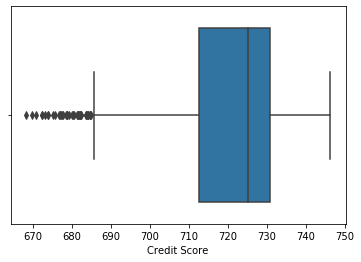

In [80]:
sns.boxplot(df['Credit Score'])

In [81]:
CAT_FEATURES.append('Credit Score Max')

In [82]:
NUM_FEATURES = ['Maximum Open Credit',
 'Current Loan Amount',
 'Annual Income',
 'Number of Open Accounts',
 'Monthly Debt',
 'Credit Score']

In [83]:
CAT_FEATURES = ['Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'tax_problems_1',
 'tax_problems_2',]

In [84]:
FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'Credit Score Max', 'Current Loan Max']

## Классификация

In [85]:
with open('model_scaler', 'rb') as f:
    scaler = pickle.load(f)

In [86]:
df[NUM_FEATURES] = scaler.transform(df[NUM_FEATURES])

In [87]:
df[NUM_FEATURES].describe()

,Maximum Open Credit,Current Loan Amount,Annual Income,Number of Open Accounts,Monthly Debt,Credit Score
count,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,1987.000000
mean,0.020540,0.015084,3.510962e+06,0.002027,0.035228,0.026980
std,1.121849,1.012272,2.183981e+06,0.966326,1.083406,0.589042
min,-5.885098,-3.003124,2.743030e+05,-3.767014,-3.256269,-2.053899
25%,-0.655194,-0.595051,2.304074e+06,-0.570224,-0.663606,-0.289252
50%,0.051896,-0.053461,3.089387e+06,-0.067750,0.076767,0.202262
75%,0.732806,0.681143,4.162798e+06,0.609418,0.735151,0.426446
max,2.712345,2.172837,3.856402e+07,2.325468,4.280378,1.040636


In [88]:
df['Credit Score Max'].value_counts()

0    2340
1     160
Name: Credit Score Max, dtype: int64

In [89]:
df['Number of Open Accounts'].describe()

count    2500.000000
mean        0.002027
std         0.966326
min        -3.767014
25%        -0.570224
50%        -0.067750
75%         0.609418
max         2.325468
Name: Number of Open Accounts, dtype: float64

In [90]:
with open('model_class.bin', 'rb') as f:
    final_model = pickle.load(f)

In [91]:
df['Maximum Open Credit'].min(), df['Maximum Open Credit'].max()

(-5.8850981078608395, 2.7123449329369502)

In [92]:
df1 = deepcopy(df)

In [93]:
y = final_model.predict(df1[FEATURE_NAMES])

In [94]:
y_proba = final_model.predict_proba(df1[FEATURE_NAMES])

In [95]:
s = pd.Series(data=(y_proba[:,1] > 0.4).astype(int), name='Credit Default')

In [100]:
s.to_csv('KKrasov_predict_default.csv', index=False)

In [97]:
y1 = (y_proba[:,1] > 0.4).astype(int)

In [98]:
len(y1[y1==1])

472

In [99]:
len(y[y==1])

211

In [100]:
df[NUM_FEATURES].describe()

,Maximum Open Credit,Current Loan Amount,Annual Income,Number of Open Accounts,Monthly Debt,Credit Score
count,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,1987.000000
mean,0.024545,0.018341,3.522012e+06,0.001768,0.030733,0.021610
std,1.117813,1.013465,2.190855e+06,0.963759,1.084822,0.591468
min,-5.859847,-3.003421,2.751662e+05,-3.757258,-3.265066,-2.067838
25%,-0.648757,-0.592512,2.311325e+06,-0.568962,-0.669015,-0.295924
50%,0.055789,-0.050285,3.099110e+06,-0.067823,0.072326,0.197614
75%,0.734249,0.685185,4.175899e+06,0.607546,0.731570,0.422721
max,2.706667,2.178635,3.868539e+07,2.319037,4.281431,1.039440


In [100]:
FEATURE_NAMES

['Maximum Open Credit',
 'Current Loan Amount',
 'Number of Open Accounts',
 'Monthly Debt',
 'Annual Income',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'Credit Score Max',
 'Current Loan Max']

In [ ]:
df = pd.read_csv('')